In [1]:
# based on https://habr.com/ru/company/mailru/blog/445834/

In [2]:
# TODO rewrite notebook logic using seaborn and plot.ly libraries

In [3]:
# import

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from string import ascii_uppercase

In [4]:
# common vars

DATASET_URL = 'https://raw.githubusercontent.com/wesm/pydata-book/2nd-edition/datasets/babynames/yob{year}.txt'
COLUMNS = ['name', 'sex', 'count']

MIN_YEAR = 1880
MAX_YEAR = 2010

In [5]:
# utils

# https://github.com/kuk/log-progress
def log_progress(sequence, every=None, size=None, name='Items'):    
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

## Visualize birth rate

In [6]:
# get data

years = np.arange(MIN_YEAR, MAX_YEAR + 1, 3)
dataframes = []

for year in log_progress(years, name='Years'):
    dataset = DATASET_URL.format(year=year)
    dataframe = pd.read_csv(dataset, names=COLUMNS)
    dataframe = dataframe.assign(year=year)
    dataframes.append(dataframe)
    
data = pd.concat(dataframes)

In [7]:
# group and aggregate

sex = data.groupby('sex')

births_men = sex.get_group('M').groupby('year')
births_men_list = births_men.aggregate(np.sum)['count'].tolist()

births_woman = sex.get_group('F').groupby('year')
births_woman_list = births_woman.aggregate(np.sum)['count'].tolist()

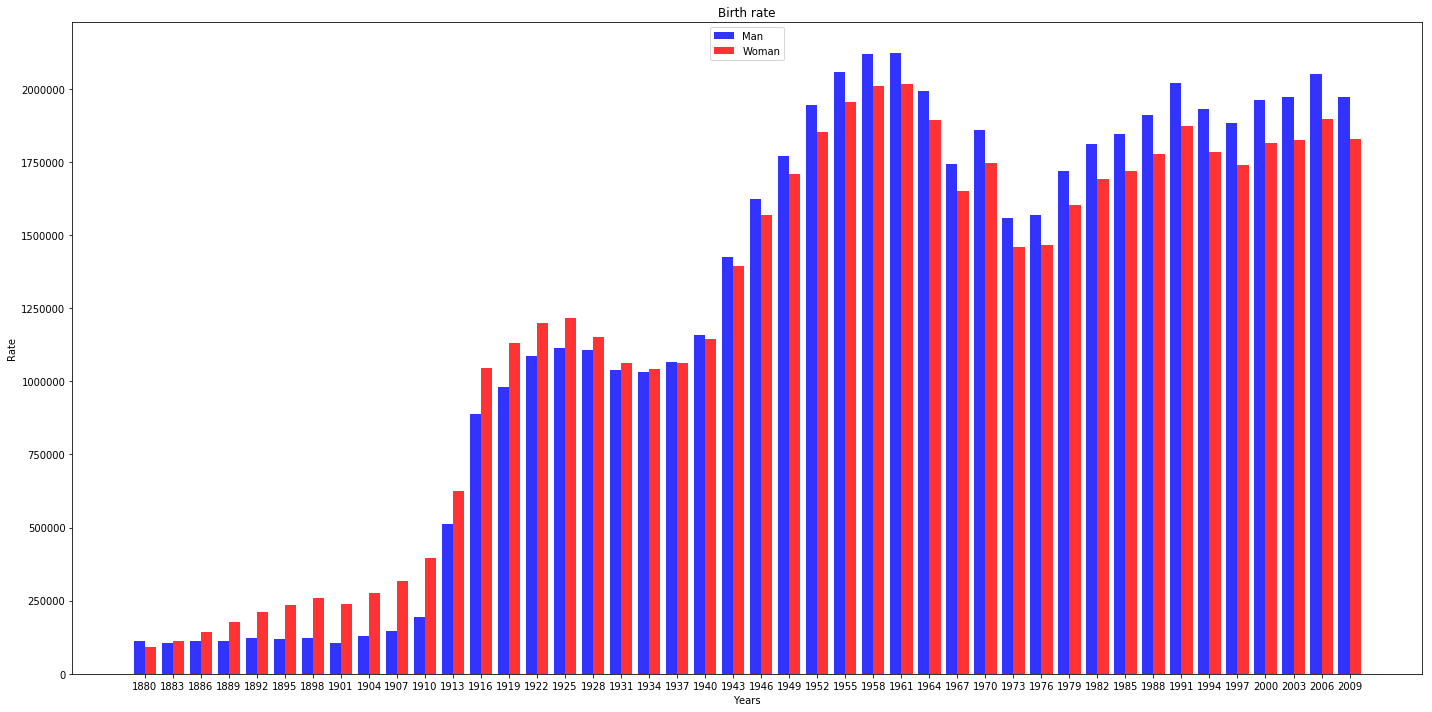

In [8]:
# visualize

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

index = np.arange(len(years))

column_width = 0.4
column_transparency = 0.8

ax.bar(
    index, 
    births_men_list, 
    column_width, 
    alpha=column_transparency, 
    color='b', 
    label='Man'
)
ax.bar(
    index + column_width, 
    births_woman_list, 
    column_width, 
    alpha=column_transparency, 
    color='r', 
    label='Woman'
)

ax.set_title('Birth rate')
ax.set_xlabel('Years')
ax.set_ylabel('Rate')
ax.set_xticklabels(years)
ax.set_xticks(index + column_width/2)
ax.legend(loc=9)  # upper center

fig.tight_layout()
plt.show()

## Find the most popular names in the history

In [9]:
# get data

years = np.arange(MIN_YEAR, MAX_YEAR + 1)
dataframes = []

for year in log_progress(years, name='Years'):
    dataset = DATASET_URL.format(year=year)
    dataframe = pd.read_csv(dataset, names=COLUMNS)
    dataframes.append(dataframe)
    
data = pd.concat(dataframes)

In [10]:
# group and aggregate

names = data.groupby('name', as_index=False).sum().sort_values('count', ascending=False)

In [11]:
# visualize

names.head(10)

,name,count
34995,James,5072771
38950,John,5061897
68084,Robert,4788050
57277,Michael,4265373
55384,Mary,4119074
85076,William,4002392
19333,David,3538748
67665,Richard,2552269
39629,Joseph,2529809
14390,Charles,2347703


## Find the most popular name in each time part

In [12]:
# get data

parts_count = 10

years = np.arange(MIN_YEAR, MAX_YEAR + 1)
part_size = int((MAX_YEAR - MIN_YEAR) / parts_count) + 1
parts = {}

def get_part_index(year):
    return int((year - MIN_YEAR) / part_size)

for year in years:
    part_index = get_part_index(year)
    part_start = MIN_YEAR + part_size * part_index
    part_end = min(MIN_YEAR + part_size * (part_index + 1), MAX_YEAR)
    parts[part_index] = '{}-{}'.format(part_start, part_end)

dataframes = []
for year in log_progress(years, name='Years'):
    dataset = DATASET_URL.format(year=year)
    dataframe = pd.read_csv(dataset, names=COLUMNS)
    dataframe = dataframe.assign(
        year=year,
        years=parts[get_part_index(year)]
    )
    dataframes.append(dataframe)

data = pd.concat(dataframes)

In [13]:
# group and aggregate

data_sums = data.groupby(['years', 'sex', 'name'], as_index=False).sum()
data_names = data_sums.iloc[
    data_sums.groupby(['years', 'sex'], as_index=False).apply(lambda x: x['count'].idxmax())
]

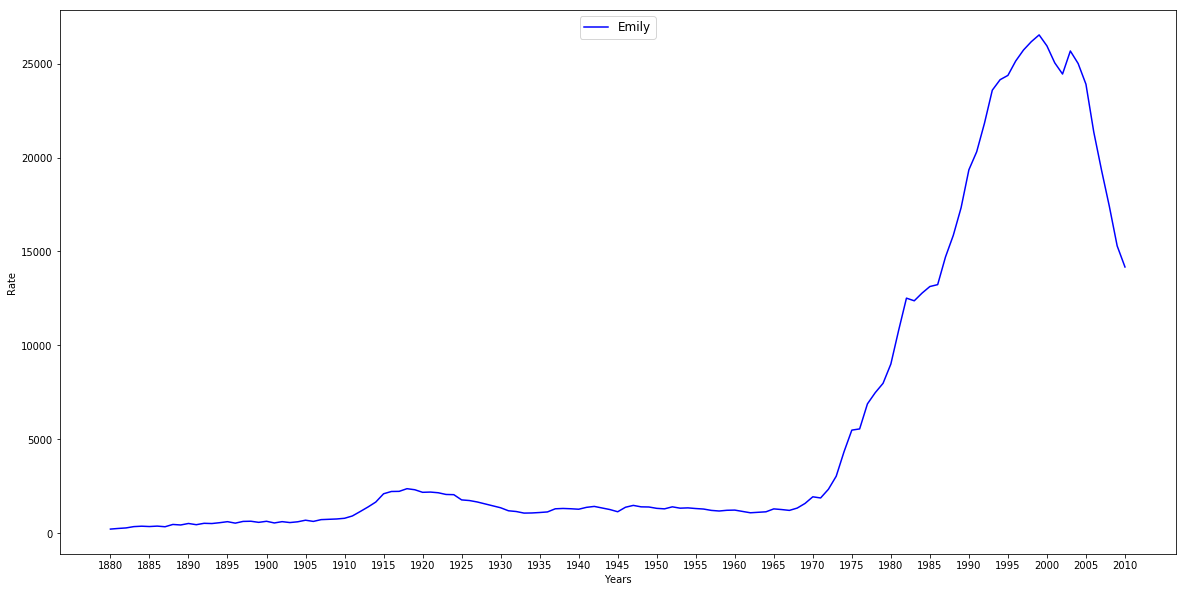

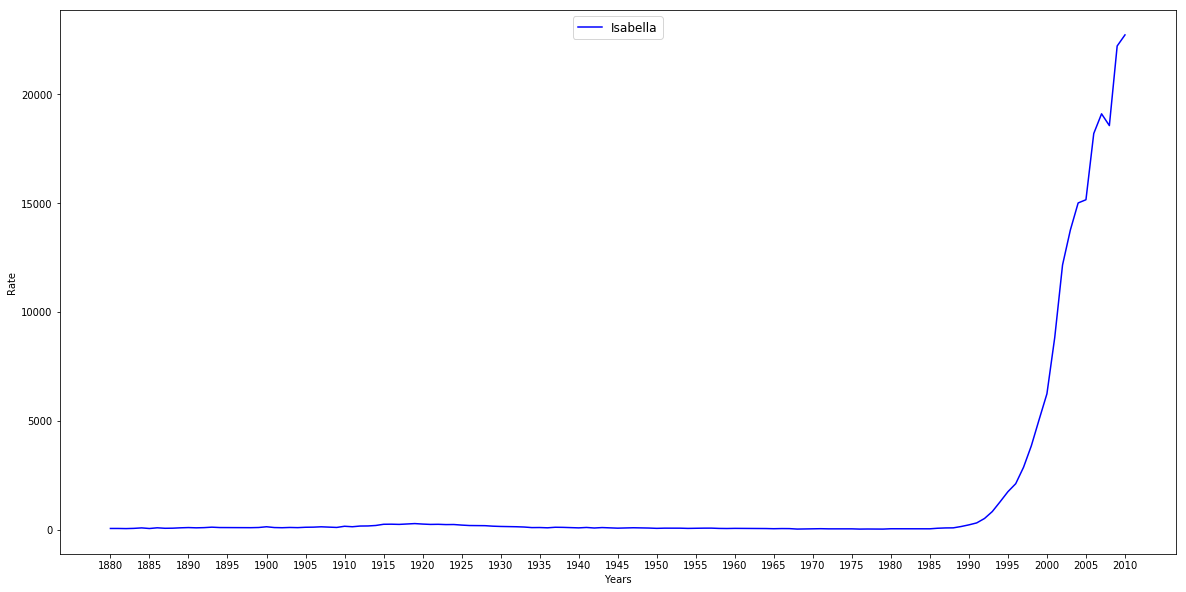

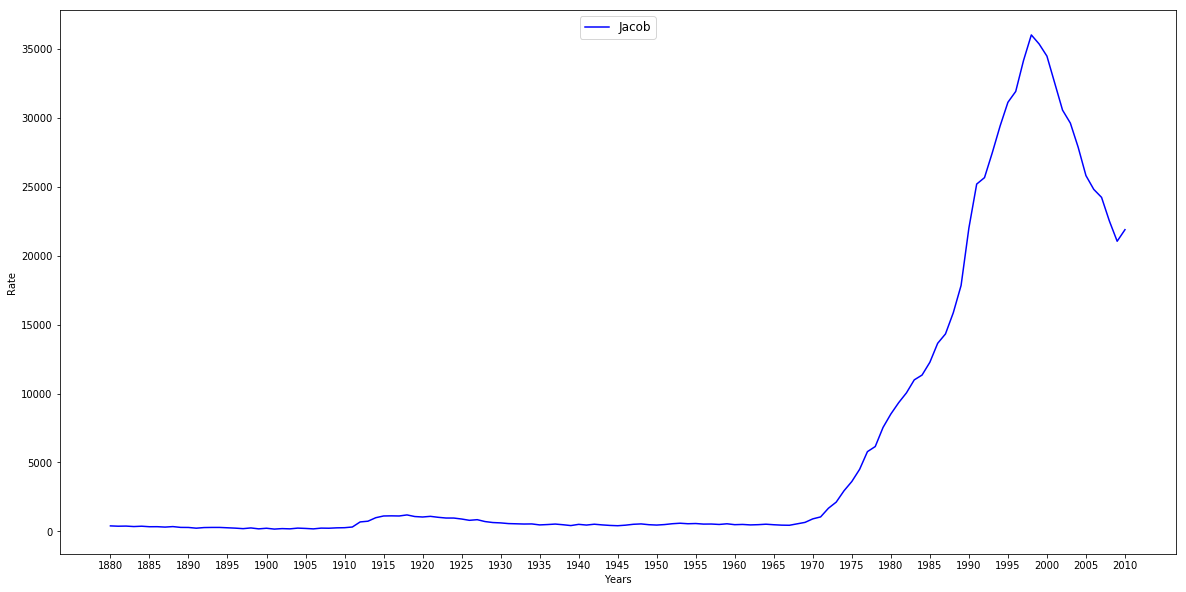

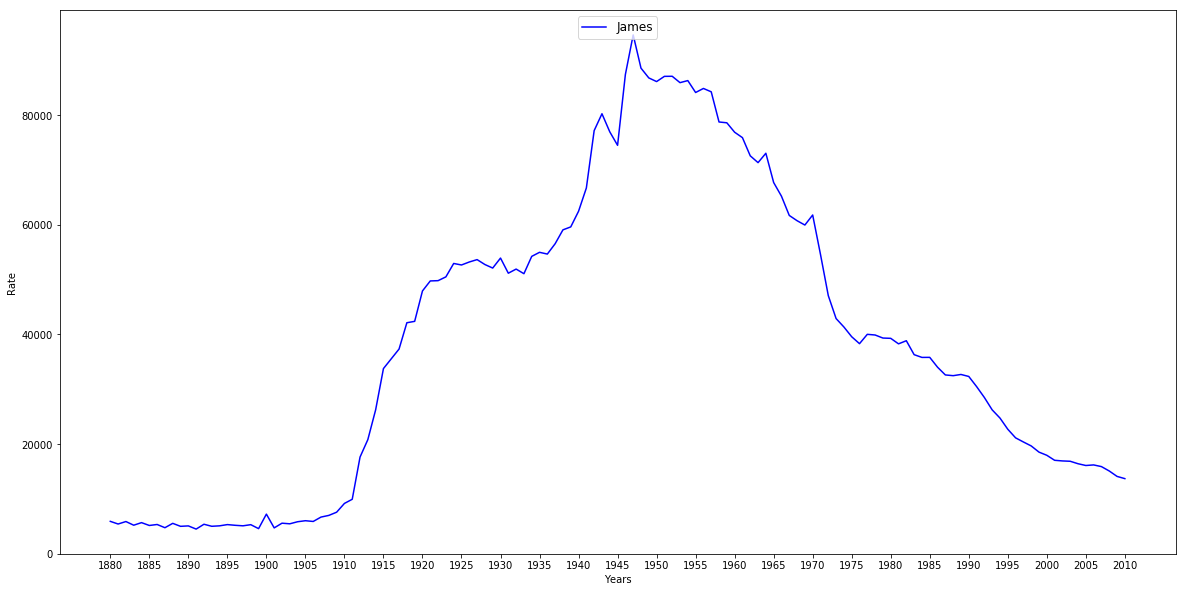

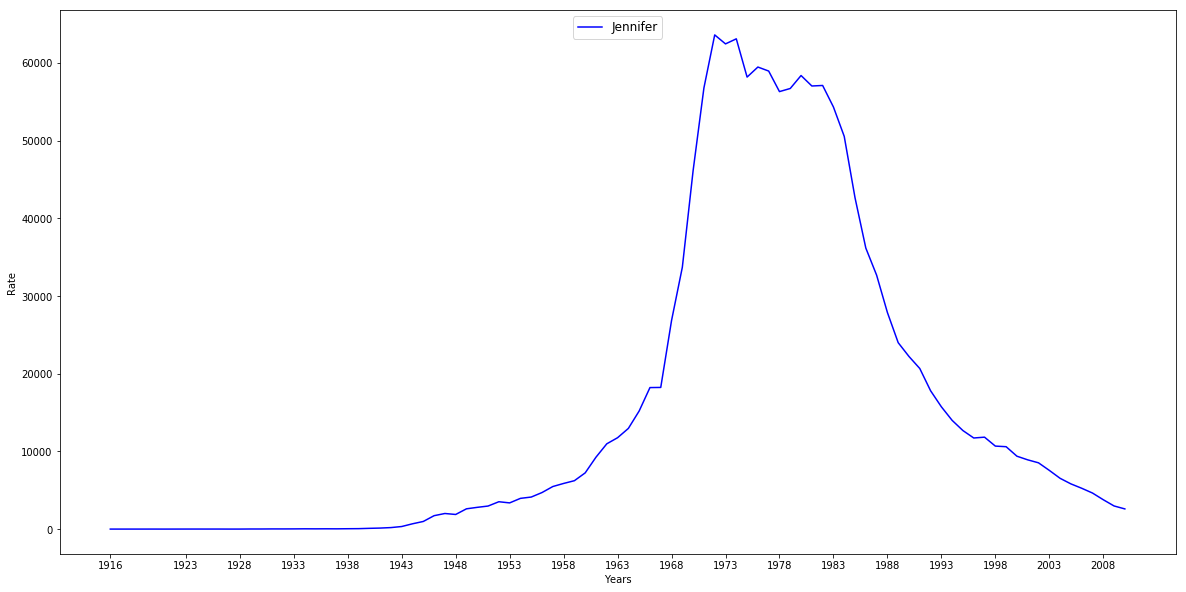

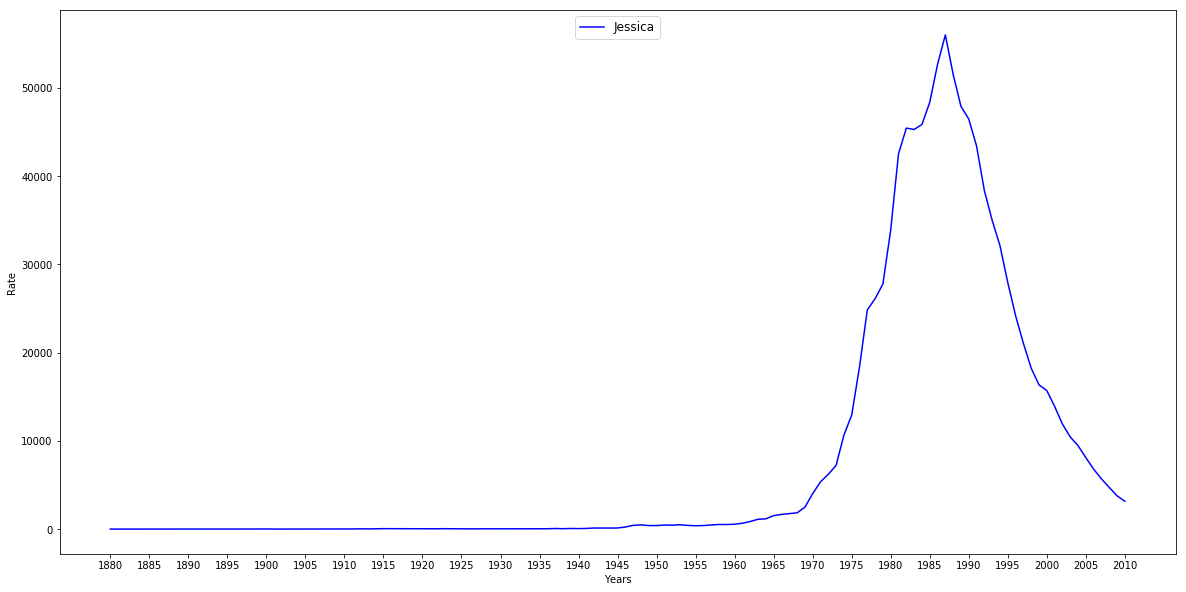

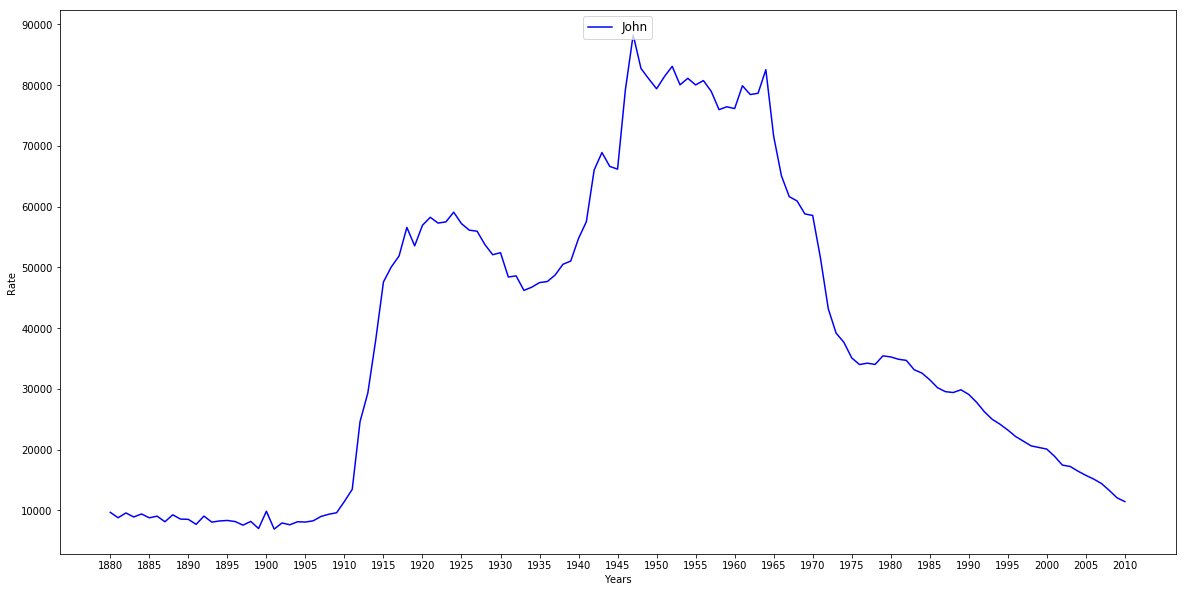

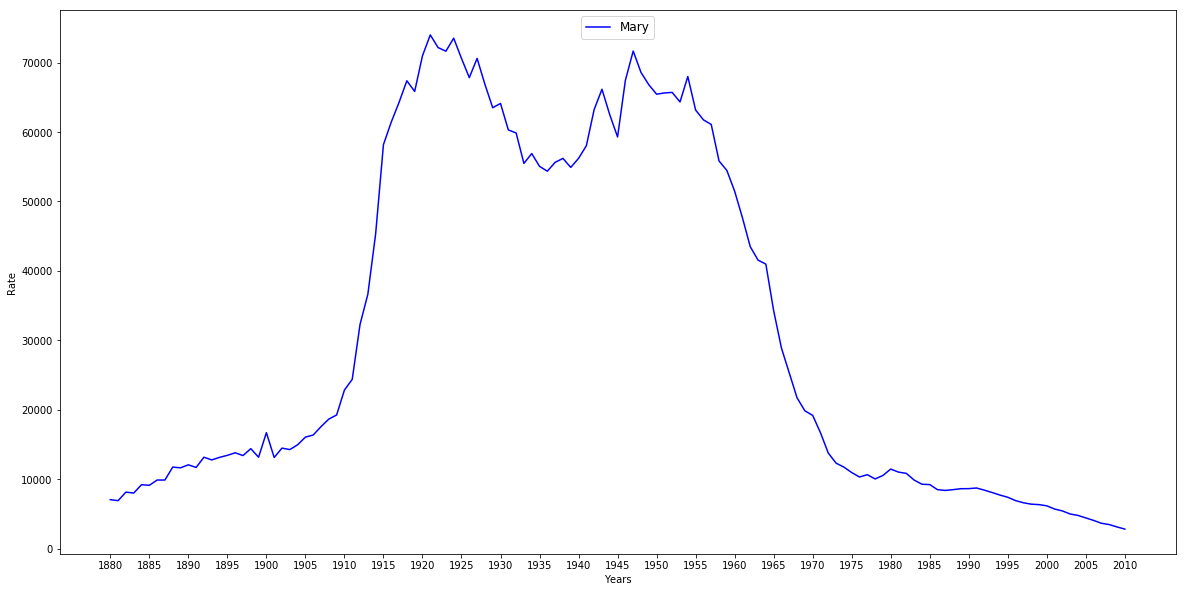

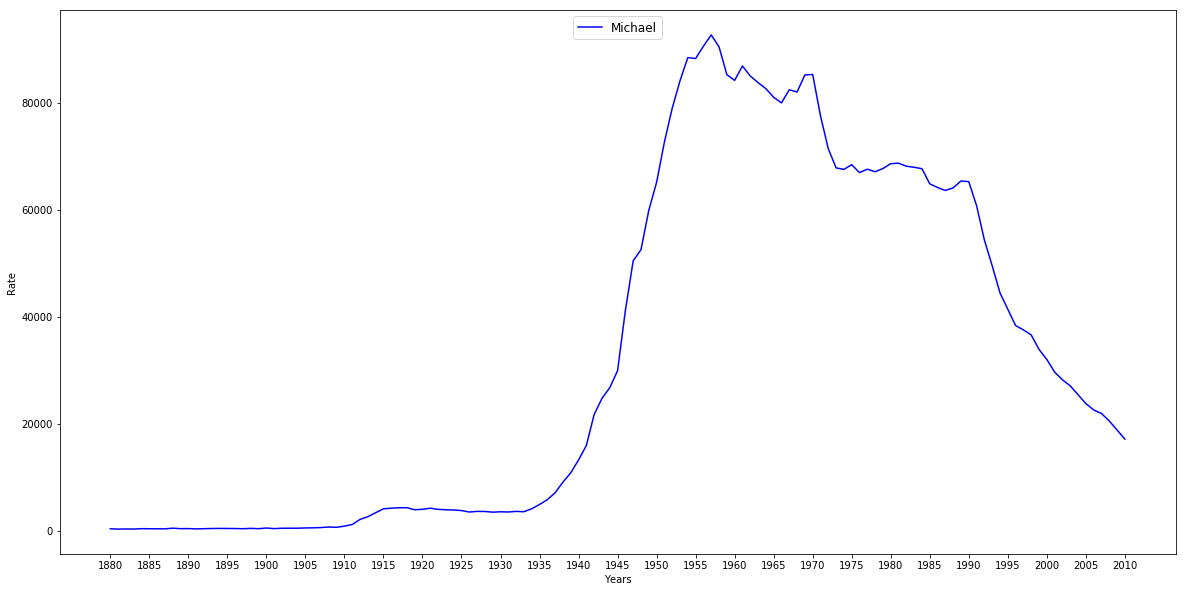

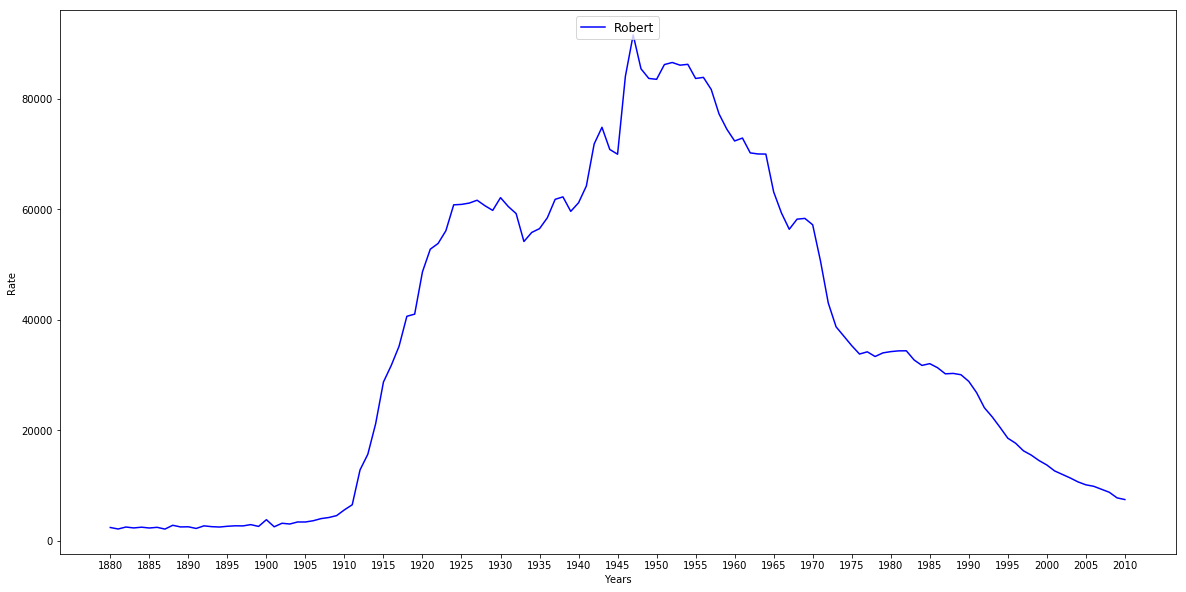

In [14]:
# visualize

for group_name, group_index in data_names.groupby(['name', 'sex']).groups.items():
    group = data.groupby(['name', 'sex']).get_group(group_name)

    fig, ax = plt.subplots()
    fig.set_size_inches(20, 10)

    label = group['name'].aggregate(np.max)
    ax.plot(group['year'], group['count'], label=label, color='b', ls='-')
    ax.set_xticks(group['year'][::5])
    
    ax.set_xlabel('Years')
    ax.set_ylabel('Rate')
    ax.legend(loc=9, fontsize=12)

    plt.show()

## Display names variety of specific percent of people for each year

In [15]:
# get data and aggregate

people_percent = 80

years = np.arange(MIN_YEAR, MAX_YEAR + 1)
data = pd.DataFrame({'year': [], 'names_count': []})

for year in log_progress(years, name='Years'):
    dataset = DATASET_URL.format(year=year)
    dataframe = pd.read_csv(dataset, names=COLUMNS)
    
    names = dataframe.groupby('name', as_index=False).sum()

    total_count = names['count'].sum()

    names['percent'] = names['count'] / total_count * 100
    names = names.sort_values(['percent'], ascending=False)
    names['cum_percent'] = names['percent'].cumsum()
    
    names_filtered = names[names['cum_percent'] < people_percent]

    data = data.append(pd.DataFrame({
        'year': [year], 
        'names_count': [names_filtered.shape[0]]
    }))

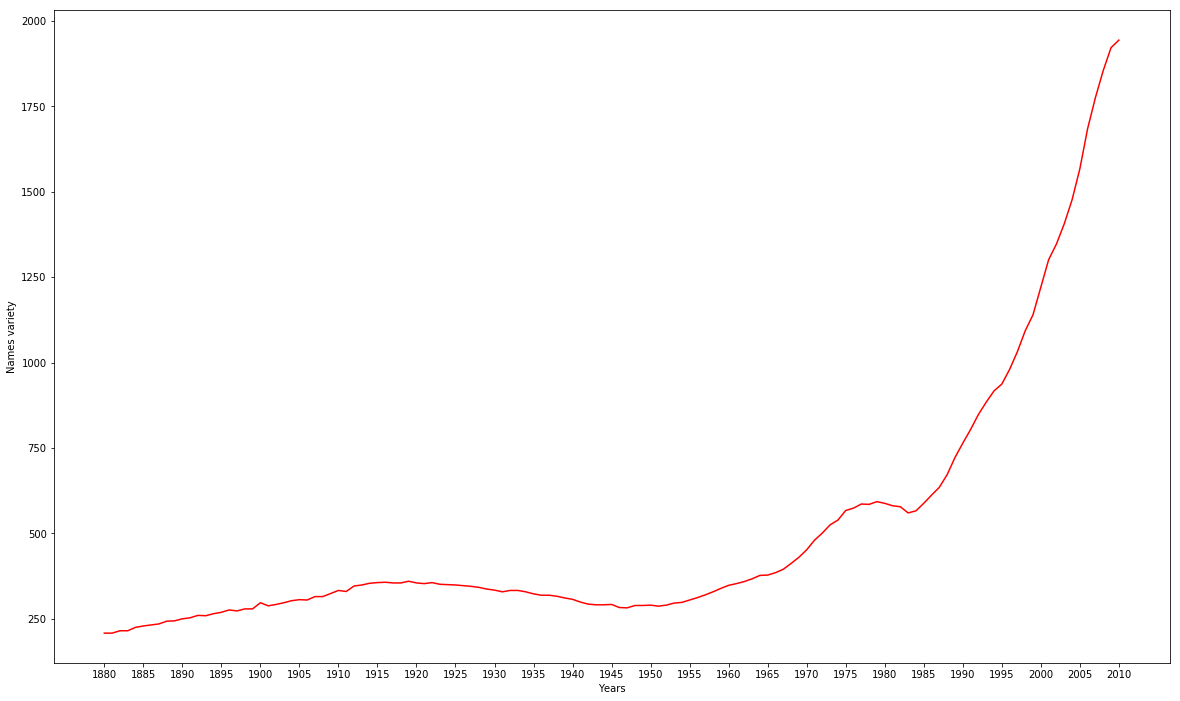

In [16]:
# visualize

fig, ax = plt.subplots()
fig.set_size_inches(20, 12)

ax.plot(data['year'], data['names_count'], color='r', ls='-')
ax.set_xticks(data['year'][::5])

ax.set_xlabel('Years')
ax.set_ylabel('Names variety')

plt.show()

## Show name's first letter distribution for several years

In [17]:
# get data and aggregate

years_count = 5  # must be not bigger than 5 because of visualization logic
years = np.linspace(MIN_YEAR, MAX_YEAR, years_count).astype(int)

dataframes = []
for year in log_progress(years, name='Years'):
    dataset = DATASET_URL.format(year=year)
    csv = pd.read_csv(dataset, names=COLUMNS)
    names = csv.groupby('name', as_index=False).sum()

    dataframe = pd.DataFrame({'letter': [], 'frequency_percent': []})
    for letter in ascii_uppercase:
        frequency = names[names.name.str.startswith(letter)].count()['count']
        frequency_percent = frequency / names.shape[0] * 100
        dataframe = dataframe.append(pd.DataFrame({
            'letter': [letter],
            'frequency_percent': [frequency_percent]
        }))

    dataframes.append(dataframe)

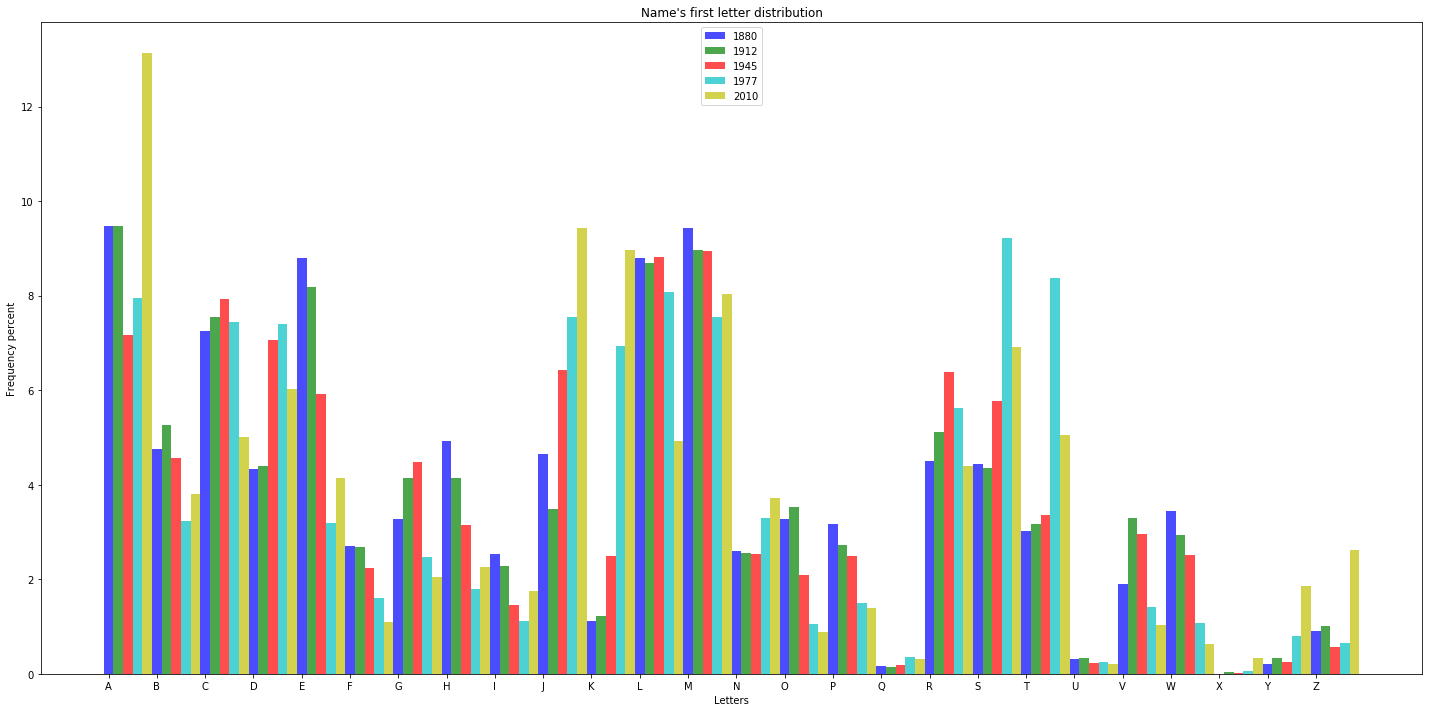

In [18]:
# visualize

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

index = np.arange(len(ascii_uppercase))
column_width = 1 / years_count
column_transparency = 0.7
colors = ['b', 'g', 'r', 'c', 'y']

for _index, dataframe in enumerate(dataframes):
    ax.bar(
        index + column_width * _index, 
        dataframe['frequency_percent'],
        column_width, 
        alpha=column_transparency, 
        color=colors[_index], 
        label=years[_index]
    )

ax.set_title('Name\'s first letter distribution')
ax.set_xlabel('Letters')
ax.set_ylabel('Frequency percent')
ax.set_xticklabels(ascii_uppercase)
ax.set_xticks(index)
ax.legend(loc=9)  # upper center

fig.tight_layout()
plt.show()

## Show famous people influence on birth rate

In [19]:
# get data

years = np.arange(MIN_YEAR, MAX_YEAR + 1)
dataframes = []

for year in log_progress(years, name='Years'):
    dataset = DATASET_URL.format(year=year)
    dataframe = pd.read_csv(dataset, names=COLUMNS)
    dataframe = dataframe.assign(year=year)
    dataframes.append(dataframe)

data = pd.concat(dataframes)

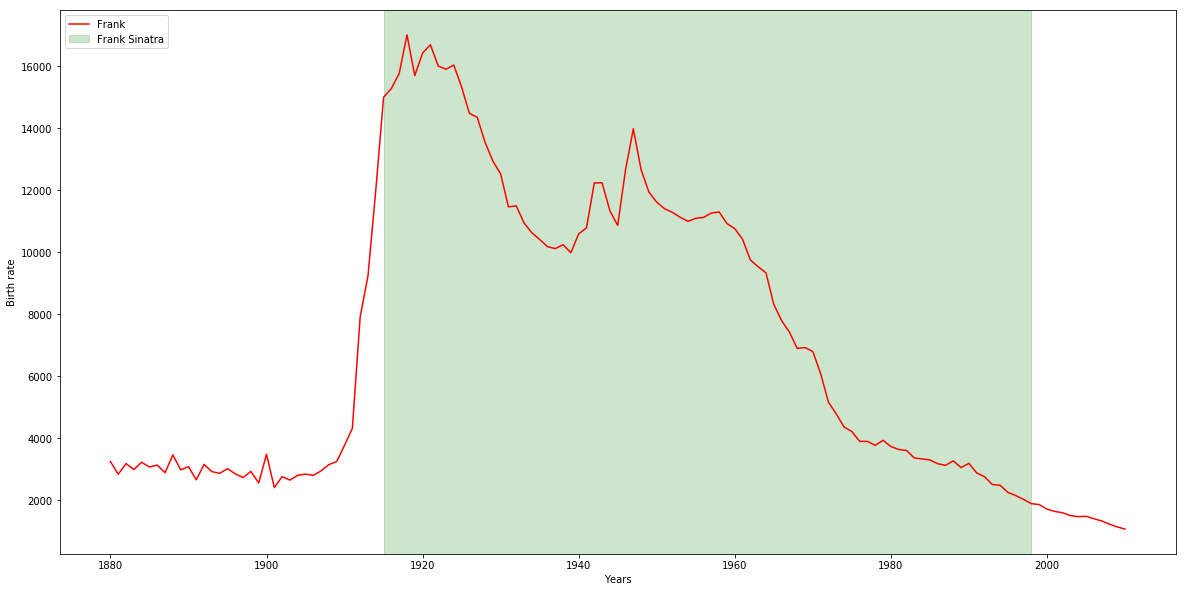

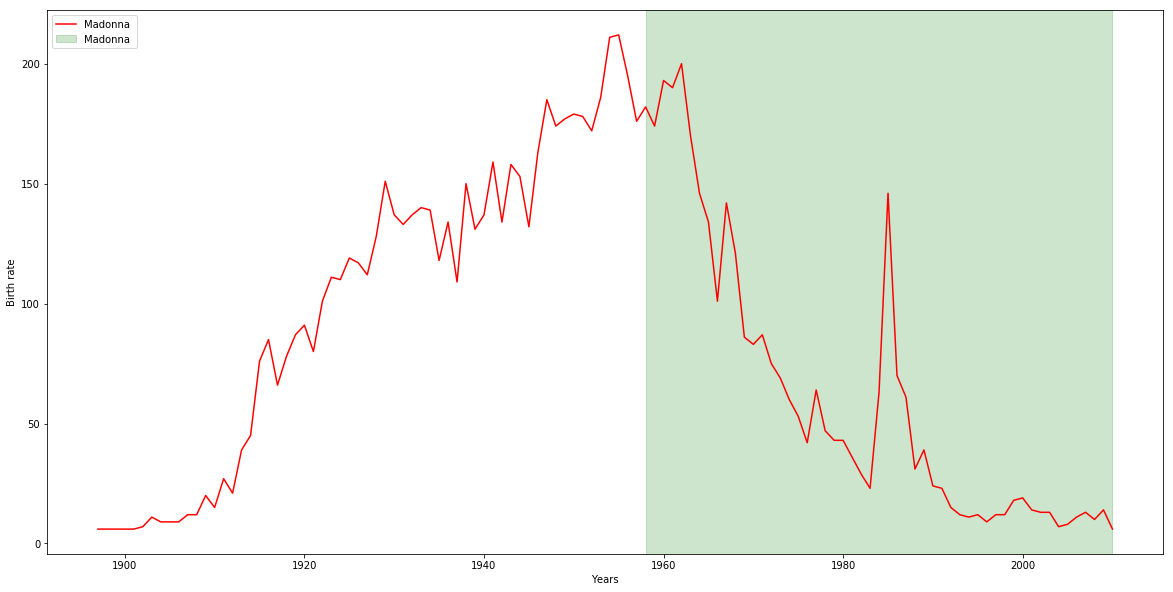

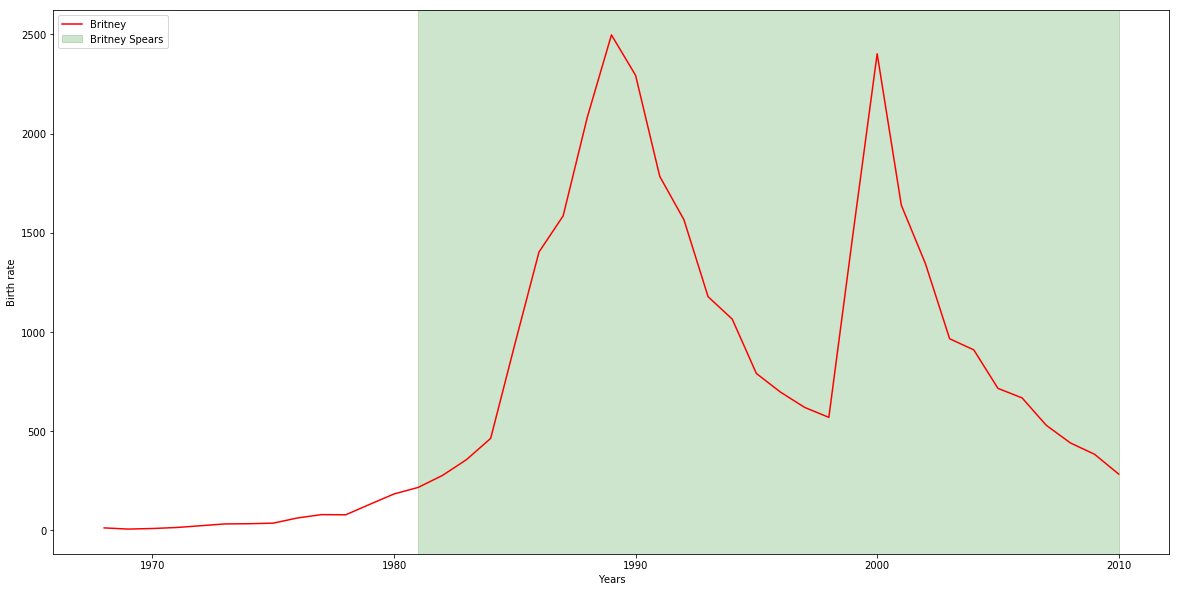

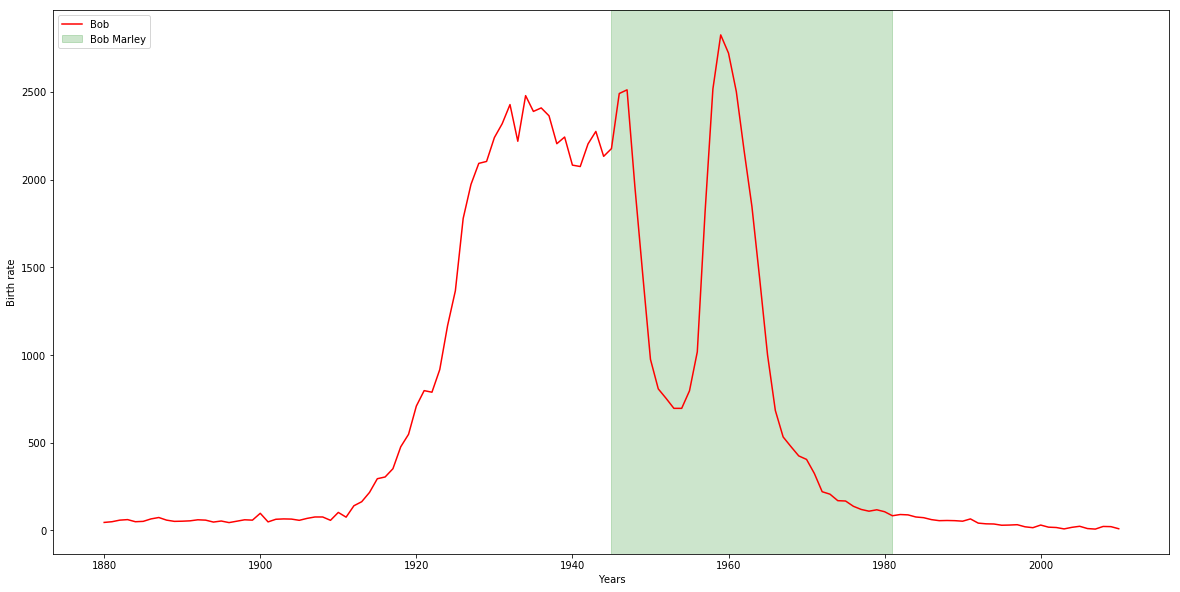

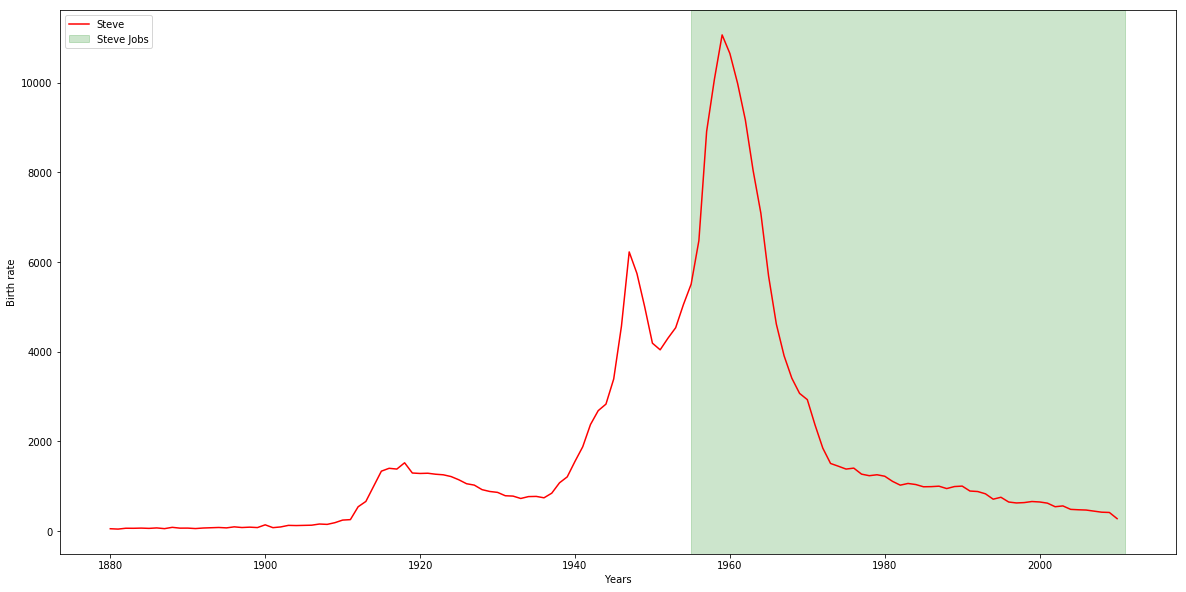

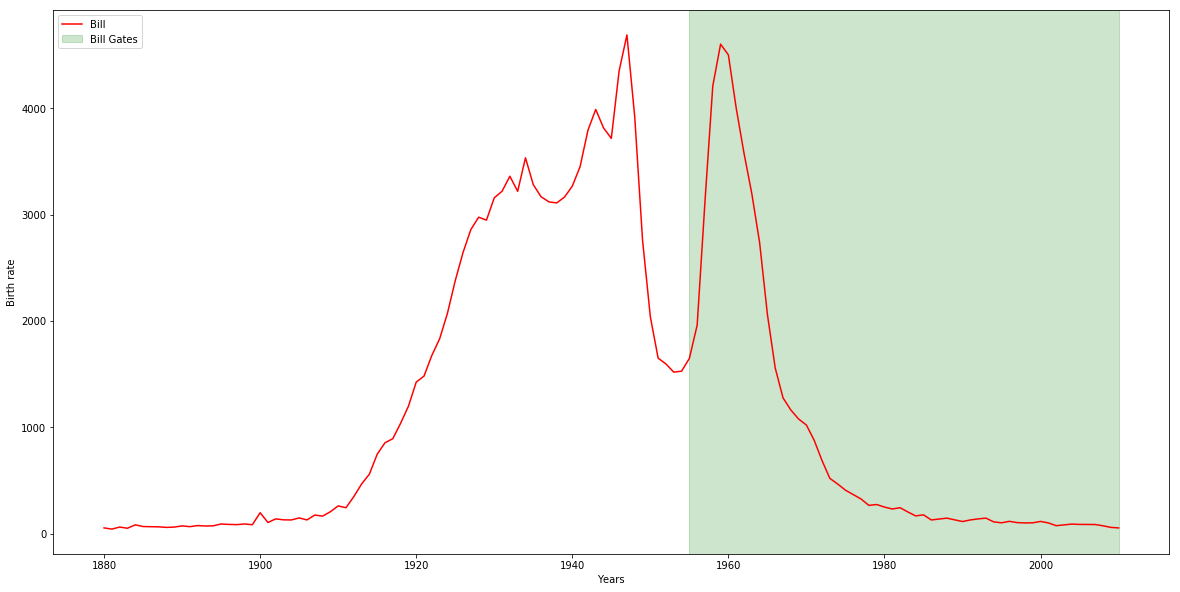

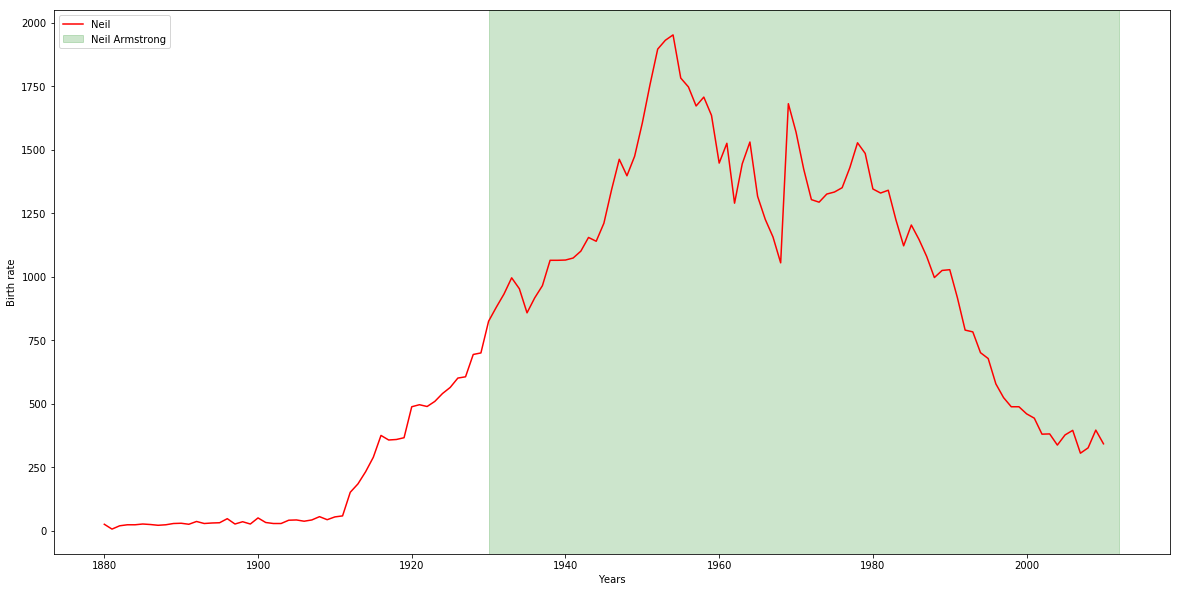

In [52]:
# visualize

celebrities = [
    {'frist_name': 'Frank', 'last_name': 'Sinatra', 'sex': 'M', 'born': 1915, 'died': 1998},
    {'frist_name': 'Madonna', 'last_name': '', 'sex': 'F', 'born': 1958, 'died': None},
    {'frist_name': 'Britney', 'last_name': 'Spears', 'sex': 'F', 'born': 1981, 'died': None},
    {'frist_name': 'Bob', 'last_name': 'Marley', 'sex': 'M', 'born': 1945, 'died': 1981},
    {'frist_name': 'Steve', 'last_name': 'Jobs', 'sex': 'M', 'born': 1955, 'died': 2011},
    {'frist_name': 'Bill', 'last_name': 'Gates', 'sex': 'M', 'born': 1955, 'died': None},
    {'frist_name': 'Neil', 'last_name': 'Armstrong', 'sex': 'M', 'born': 1930, 'died': 2012},
]

for celebrity in celebrities:
    name = celebrity['frist_name']
    
    dataframe = data[(data.name == name) & (data.sex == celebrity['sex'])]
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 10)

    ax.plot(
        dataframe['year'], 
        dataframe['count'], 
        label=name,
        color='r', 
        ls='-'
    )
    plt.axvspan(
        celebrity['born'], 
        celebrity['died'] or dataframe.max()['year'],
        label="{} {}".format(name, celebrity['last_name']),
        color='g',
        alpha=0.2
    )

    ax.set_xlabel('Years')
    ax.set_ylabel('Birth rate')
    ax.legend(loc=2)  # upper left

    plt.show()